## Description

Сделать проект по классификации наличия святого Георгия на изображении. В папке есть два файла со списком картинок: Георгиев и не Георгиев. Нужно сделать jupyter notebook, в котором будет обучаться модель классификации Георгиев и не Георгиев.

Скачать файлы можно при помощи wget: `wget --random-wait -i filename.txt`. Ссылка на папку для копирования: https://drive.google.com/drive/folders/1hXAjwpBj6shfWd1taWMFpSqelFCzi6KJ?usp=sharing

#### Метрика:
- Accuracy

#### Публичность и переиспользование:
- У всех ячеек с открытием картинок должен быть удален output, чтобы не нарушать ничьих прав.

In [1]:
import wget
import os

import cv2
import mahotas
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

In [2]:
mahotas.__version__

'1.4.11'

In [3]:
wget.__version__

'3.2'

## Downloading & reading

In [4]:
# Reading csv with removing duplicates:
source_g = pd.read_csv('georges.csv', header=None, names=['url']).drop_duplicates(subset=['url'], keep=False)
source_ng = pd.read_csv('non_georges.csv', header=None, names=['url']).drop_duplicates(subset=['url'], keep=False)

In [5]:
source_g.head()

,url
1,https://i.pinimg.com/736x/47/b9/9a/47b99a2ddcd...
2,https://i.pinimg.com/736x/90/e8/90/90e890f054b...
3,https://i.pinimg.com/736x/0a/71/6f/0a716f6f14e...
4,https://i.pinimg.com/736x/f1/95/be/f195bea0b78...
5,https://i.pinimg.com/736x/78/da/54/78da54b8fa9...


In [7]:
print('Количество изображений с Георгием: {}\nКоличество изображений без Георгия: {}'.format(len(source_g),
                                                                                             len(source_ng)))

Количество изображений с Георгием: 2092
Количество изображений без Георгия: 3314


Оверсемплингом заниматься не планирую, поэтому просто сравняю число загружаемых картинок в обоих классах по миноритарному:

In [8]:
# Index equation:
source_ng = source_ng.iloc[:source_g.shape[0], :]
len(source_ng)

2092

In [9]:
# Lists with sources & class names:
sources = [source_g, source_ng]
label_names = ['georges', 'non_georges']

In [14]:
# Data downloading & paths creating:
def get_download(path_names, sources):
    
    # Current directory:
    directory = os.getcwd()
    
    # File paths:
    paths = [os.path.join(directory, name) for name in path_names]
    
    # Paths creating:
    for path in paths:
        try:
            os.mkdir(path)
        except OSError as error:
            print(error)
        else:
            print('Successfully created directory {}'.format(path))
    
    # Data downloading:
    for path, source in zip(paths, sources):
        source.loc[:, 'url'].apply(lambda x: wget.download(x, out=os.path.join(directory, path)))
        
    return paths

In [16]:
# Start:
paths = get_download(label_names, sources)

Successfully created directory C:\Users\Che\Enter_Ideas_Task1\georges
Successfully created directory C:\Users\Che\Enter_Ideas_Task1\non_georges
100% [............................................................................] 132872 / 132872

In [17]:
# Reading images to arrays:
def get_data(paths):
    
    # Reading with resizing:
    array_g = [cv2.resize(cv2.imread(os.path.join(paths[0], x)), (300, 300), interpolation = cv2.INTER_CUBIC)
                          for x in os.listdir(paths[0])]
    
    array_ng = [cv2.resize(cv2.imread(os.path.join(paths[1], x)), (300, 300), interpolation = cv2.INTER_CUBIC)
                           for x in os.listdir(paths[1])]
    
    return array_g, array_ng

In [19]:
%%time
# Get data:
x_g, x_ng = get_data(paths)

# Targets creating:
y = np.ravel([1 for x in range(len(x_g))] + [0 for x in range(len(x_ng))])

# Arrays concatenate:
X = np.vstack((x_g, x_ng))

X.shape

Wall time: 56.4 s


(4184, 300, 300, 3)

In [20]:
# Data splitting:
data_train, data_test, label_train, label_test = train_test_split(X, y,
                                                                  random_state=0,
                                                                  stratify=y,
                                                                  shuffle=True,
                                                                  test_size=0.2)

In [ ]:
# Изображения с Георгием (output не осуществляю, следуя условиям задачи)
fig, axes = plt.subplots(2, 5, figsize=(18, 6))
fig.suptitle('First 10 images with George in data', fontsize=14)

for x in range(0, 10):
    axes[x//5, x%5].imshow(X[x])

plt.show()

## Feature extraction

Обучение на имеющихся данных (без предобработки) результата практически не принесло, получилась константная модель. Конечно, хорошо выраженные контуры на датасете типа MNIST могли бы зайти, но в данном кейсе изображения намного сложнее. Я решил сгенерировать несколько признаков, обобщающих текстуру, цветовую гистограмму и моменты изображения, а также сделал небольшую аугментацию. Функцию обернул в трансформер для дальнейшего использования в пайплайне препроцессинга.

In [22]:
# Feature extracting for array of images: Moments, Haralick textures & Color Histogram:
def get_features(data):
    
    all_features = []
    
    for x in data:
        # Augmentations:
        img_flip = np.fliplr(x)
        img_rot90 = np.rot90(x)
        img_rot270 = np.rot90(x, 3)
    
        # Convert the image to grayscale & HSV color-space:
        img_gray = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
        img_gray_flip = cv2.cvtColor(img_flip, cv2.COLOR_BGR2GRAY)
        img_gray_rot90 = cv2.cvtColor(img_rot90, cv2.COLOR_BGR2GRAY)
        img_gray_rot270 = cv2.cvtColor(img_rot270, cv2.COLOR_BGR2GRAY)
        
        img_hsv = cv2.cvtColor(x, cv2.COLOR_BGR2HSV)
        img_hsv_flip = cv2.cvtColor(img_flip, cv2.COLOR_BGR2HSV)
        img_hsv_rot90 = cv2.cvtColor(img_rot90, cv2.COLOR_BGR2HSV)
        img_hsv_rot270 = cv2.cvtColor(img_rot270, cv2.COLOR_BGR2HSV)
    
        # Compute Moments, Haralick & color histogram features:
        moment = np.asarray(list(cv2.moments(img_gray).values())).flatten()
        moment_flip = np.asarray(list(cv2.moments(img_gray_flip).values())).flatten()
        moment_rot90 = np.asarray(list(cv2.moments(img_gray_rot90).values())).flatten()
        moment_rot270 = np.asarray(list(cv2.moments(img_gray_rot270).values())).flatten()
        
        haralick = mahotas.features.haralick(img_gray).mean(axis=0)
        haralick_flip = mahotas.features.haralick(img_gray_flip).mean(axis=0)
        haralick_rot90 = mahotas.features.haralick(img_gray_rot90).mean(axis=0)
        haralick_rot270 = mahotas.features.haralick(img_gray_rot270).mean(axis=0)
        
        hist = cv2.calcHist([img_hsv],
                            [0, 1, 2],
                            None,
                            [6, 6, 6],
                            [0, 256, 0, 256, 0, 256]).flatten()
        hist_flip = cv2.calcHist([img_hsv_flip],
                            [0, 1, 2],
                            None,
                            [6, 6, 6],
                            [0, 256, 0, 256, 0, 256]).flatten()
        hist_rot90 = cv2.calcHist([img_rot90],
                            [0, 1, 2],
                            None,
                            [6, 6, 6],
                            [0, 256, 0, 256, 0, 256]).flatten()
        hist_rot270 = cv2.calcHist([img_rot270],
                            [0, 1, 2],
                            None,
                            [6, 6, 6],
                            [0, 256, 0, 256, 0, 256]).flatten()
    
        # Normalize the histogram:
        cv2.normalize(hist, hist)
        cv2.normalize(hist_flip, hist_flip)
        cv2.normalize(hist_rot90, hist_rot90)
        cv2.normalize(hist_rot270, hist_rot270)
    
        # Concatenate features:
        features = np.hstack([moment, haralick, hist,
                              moment_flip, haralick_flip, hist_flip,
                              moment_rot90, haralick_rot90, hist_rot90,
                              moment_rot270, haralick_rot270, hist_rot270])
        
        # Append new data to array:
        all_features.append(features)

    return all_features

In [23]:
# Convert to transformer:
Extractor = FunctionTransformer(get_features)

## Data preparation

In [24]:
# Simple pipeline for data preprocessing:
preprocessor = Pipeline([('Extractor', Extractor),
                         ('Scaler', MinMaxScaler())])

In [25]:
%%time
# Get prep. data:
x_train = preprocessor.fit_transform(data_train)
x_test = preprocessor.fit_transform(data_test)

Wall time: 10min 23s


In [26]:
x_train.shape

(3347, 1012)

## GridSearch, training

In [27]:
# Classifiers:
rfc = RandomForestClassifier(random_state=0,
                             n_jobs=-1)
# Params for clfs:
params_rfc = {'n_estimators': [80, 120, 140, 160, 180],
              'max_depth': [6, 8, 10],
              'min_samples_split': [2, 4, 6],
              'min_samples_leaf': [1, 3]}

In [28]:
%%time
# Searcher:
grid = GridSearchCV(rfc, params_rfc,
                    scoring='accuracy',
                    cv=3, n_jobs=-1)
# Start training:
grid.fit(x_train, label_train)
        
# Results:
print('Classifier: {}\nWith parameters: {}\nHas best Accuracy: {}\n'.format(rfc,
                                                                            grid.best_params_,
                                                                            grid.best_score_))

Classifier: RandomForestClassifier(n_jobs=-1, random_state=0)
With parameters: {'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 140}
Has best Accuracy: 0.7340825926461685

Wall time: 5min 43s


In [31]:
print('Mean accuracy on 3-fold validation data: {}\n\n'.format(round(cross_val_score(grid.best_estimator_, x_test, label_test,
                                                                                     scoring='accuracy').mean(), 3)),
      classification_report(label_test, grid.best_estimator_.predict(x_test), target_names=label_names))

Mean accuracy on 3-fold validation data: 0.702

               precision    recall  f1-score   support

     georges       0.70      0.74      0.72       419
 non_georges       0.73      0.69      0.71       418

    accuracy                           0.71       837
   macro avg       0.71      0.71      0.71       837
weighted avg       0.71      0.71      0.71       837



In [51]:
# 
rf = RandomForestClassifier(n_estimators=80, 
                            random_state=0,
                            max_depth=14,
                            n_jobs=-1)

rf.fit(x_train, label_train)

RandomForestClassifier(max_depth=14, n_estimators=80, n_jobs=-1, random_state=0)

In [52]:
print('Mean accuracy on 3-fold validation data: {}\n\n'.format(round(cross_val_score(rf, x_test, label_test,
                                                                                     scoring='accuracy').mean(), 3)),
      classification_report(label_test, rf.predict(x_test), target_names=label_names))

Mean accuracy on 3-fold validation data: 0.701

               precision    recall  f1-score   support

     georges       0.70      0.78      0.73       419
 non_georges       0.75      0.66      0.70       418

    accuracy                           0.72       837
   macro avg       0.72      0.72      0.72       837
weighted avg       0.72      0.72      0.72       837



In [34]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None,
                        train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(12, 6))

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=3, n_jobs=-1,
                                                            train_sizes=train_sizes,
                                                            return_times=False)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt

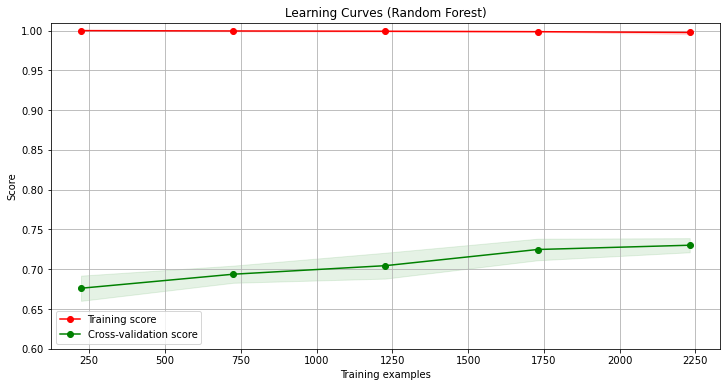

In [54]:
fig, axes = plt.subplots(1, 1, figsize=(12, 6))

title = "Learning Curves (Random Forest)"

estimator = rf #####
plot_learning_curve(estimator, title, x_train, label_train, axes=axes, ylim=(0.6, 1.01)) #####

title = r"Learning Curves"

plt.show()

Модель обучена на 80% данных.

Предполагаю, что с ростом количества данных качество классификации существенно увеличится.

Это моё первое погружение в CV, и по объективным причинам задача выполнена с использованием классического ML.
Возможно, я получил неплохой результат, если сравнивать с non-pretrained сетями.
Далее буду погружаться в DL-фреймворки.

In [ ]:
# Классифицируем и отобразим первые 10 картинок из валидационной выборки:
fig, axes = plt.subplots(2, 5, figsize=(18, 8))
fig.suptitle('Classificated images', fontsize=14)

prep_data = preprocessor.fit_transform(data_test[:10])
predictions = rf.predict(prep_data)
label_pred = list(map(lambda x: 'George' if x==0 else 'Non George', predictions))

for idx, name in zip(range(0, 10), label_pred):
    axes[idx//5, idx%5].imshow(data_test[idx])
    axes[idx//5, idx%5].set_title(name)
    
plt.show()